In [18]:
# add autoreload
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re

import os
from collections import defaultdict

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score, multilabel_confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
from keras.utils import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer as KerasTokenizer
from keras.models import Sequential
from keras import layers, utils
from keras import optimizers
import tensorflow as tf

import spacy

from sklearn.preprocessing import LabelEncoder
import gc

from typing import Callable, Tuple, Dict, List, Literal

In [3]:
# TODO: add pre-trained word embeddings
# Generic Spacy
# Medical Dutch

In [4]:
os.chdir('T://lab_research/RES-Folder-UPOD/Echo_label/E_ResearchData/2_ResearchData')

In [5]:
os.listdir("./echo_doc_labels")

['aortic_regurgitation.jsonl',
 'aortic_stenosis.jsonl',
 'diastolic_dysfunction.jsonl',
 'lv_dil.jsonl',
 'lv_syst_func.jsonl',
 'merged_labels.jsonl',
 'mitral_regurgitation.jsonl',
 'pe.jsonl',
 'rv_dil.jsonl',
 'rv_syst_func.jsonl',
 'tricuspid_regurgitation.jsonl',
 'wma.jsonl']

In [21]:
#  settings
embedding_dim = 256
max_len = 200
num_words_in_vocab = 5_000
num_epochs = 50
num_folds = 10
Class = 'pe' # aortic_regurgitation, lv_sys_func, None to run all  
batch_size = 128
ModelType = 'cnn' # bigru, bilstm, cnn
ProcessorType = "cpu" if len(tf.config.experimental.list_physical_devices("GPU"))==0 else "gpu"
Splitting = 'from_file' # CV or from_file
UseClassWeights = False
LR = 0.0005
dilation=1
num_layers = 128
lemmatize = True
lowercase = False
pre_trained_embeddings = False
deabbreviator = False # TODO: replace abbreviations
typo_removal = False # TODO: remove typos
filter_reports = True

In [7]:
print(ProcessorType)

cpu


In [8]:
plt.style.use('ggplot')
if lemmatize | pre_trained_embeddings:
    nlp = spacy.load("nl_core_news_lg", disable = ['parser','ner'])    

In [9]:
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(probs, labels, threshold=0.5):
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    
    y_true = labels
    #y_true = tf.keras.backend.eval(y_true)
    #y_pred = tf.keras.backend.eval(y_pred)
    
    f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
    f1_weighted = f1_score(y_true=y_true, y_pred=y_pred, average='weighted')
    f1_micro = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    prec_macro = precision_score(y_true=y_true, y_pred=y_pred, average='macro')
    prec_weighted = precision_score(y_true=y_true, y_pred=y_pred, average='weighted')
    prec_micro = precision_score(y_true=y_true, y_pred=y_pred, average='micro')
    recall_macro = recall_score(y_true=y_true, y_pred=y_pred, average='macro')
    recall_weighted = recall_score(y_true=y_true, y_pred=y_pred, average='weighted')
    recall_micro = recall_score(y_true=y_true, y_pred=y_pred, average='micro')
    try:
        roc_auc_weighted = roc_auc_score(y_true, probs, average = 'weighted')
        roc_auc_macro = roc_auc_score(y_true, probs, average = 'macro')
        roc_auc_micro = roc_auc_score(y_true, probs, average = 'micro')
    except ValueError:
        roc_auc_weighted = None
        roc_auc_macro = None
        roc_auc_micro = None

    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1_macro': f1_macro,
               'f1_weighted': f1_weighted,
               'f1_micro': f1_micro,
               'prec_macro': prec_macro,
               'prec_weighted': prec_weighted,
               'prec_micro': prec_micro,
               'recall_macro': recall_macro,
               'recall_weighted': recall_weighted,
               'recall_micro': recall_micro,
               'roc_auc_macro': roc_auc_macro,
               'roc_auc_weighted': roc_auc_weighted,
               'roc_auc_micro': roc_auc_micro,
               'accuracy': accuracy}
    return metrics
     


In [10]:
# inference pipe
def tokenize_and_pad(x, tokenizer, maxlen = 256):
    toks = tokenizer.texts_to_sequences(x)
    toks_padded = pad_sequences(toks, padding = 'post', maxlen = maxlen)
    return toks_padded

def evaluate_model(clf, labels):
    probas = clf.predict(X_test)
    cf_matrix = confusion_matrix(np.argmax(labels, axis=1),
                                 np.argmax(probas, axis=1))

    return cf_matrix


In [11]:
# Stratified cross-validation

def fold_indices(targets: pd.Series=None, stratified: bool=True, seed: int=42, numfolds: int=10)->Tuple[List,List]:
    if stratified:
        splitter = StratifiedKFold(n_splits=numfolds, shuffle=True, random_state=seed)
        _Targets = targets
    else:
        splitter = KFold(n_splits=numfolds, shuffle=True, random_state=seed)
        _Targets = None

    train_indcs, test_indcs = [], []
    for train_index, test_index in splitter.split(X=targets, y=_Targets):
        train_indcs.append(train_index)
        test_indcs.append(test_index)

    return zip(train_indcs, test_indcs)

In [12]:
class CustomMetrics(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super(CustomMetrics, self).__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = self.model.predict(self.validation_data[0])
        val_targ = self.validation_data[1]

        _val_metrics = multi_label_metrics(val_targ, val_predict)
        for name, value in _val_metrics.items():
            logs['val_' + name] = value

        print(" — val_f1_macro: %f — val_accuracy: %f" % (logs['val_f1_macro'], logs['val_accuracy']))
        return

In [13]:
def CurrentModel(modelselection: Literal['bigru', 'bilstm', 'cnn'], 
                 embeddingdim: int=128, 
                 maxlen: int=256, 
                 vocabsize: int=50_000,
                 numclasses: int=5,
                 learningrate: float=0.001,
                 num_layers: int=128,
                 pre_trained_vectors: bool=False,
                 dilation=4):
    model = Sequential()
    if pre_trained_vectors:
        num_dense = 20
    else:
        num_dense = 10
    if modelselection =='bigru':
        if pre_trained_vectors:
            model.add(layers.Bidirectional(layers.GRU(num_layers), input_shape=(maxlen, embeddingdim)))
        else:
            model.add(layers.Embedding(vocabsize, embeddingdim, input_length=maxlen))
            model.add(layers.Bidirectional(layers.GRU(num_layers)))
        model.add(layers.Dense(num_dense, activation = 'relu'))
        model.add(layers.Dense(numclasses, activation = 'softmax'))
        model.compile(optimizer = optimizers.Adam(learning_rate=learningrate),
                      loss = 'categorical_crossentropy', 
                      metrics = ['accuracy'])
    elif modelselection =='bilstm':
        if pre_trained_vectors:
            model.add(layers.Bidirectional(layers.LSTM(num_layers), input_shape=(maxlen, embeddingdim)))
        else:
            model.add(layers.Embedding(vocabsize, embeddingdim, input_length=maxlen))
            model.add(layers.Bidirectional(layers.LSTM(num_layers)))
        model.add(layers.Dense(num_dense, activation = 'relu'))
        model.add(layers.Dense(numclasses, activation = 'softmax'))
        model.compile(optimizer = optimizers.Adam(learning_rate=learningrate),
                      loss = 'categorical_crossentropy',
                      metrics = ['accuracy'])
    elif modelselection =='cnn':
        if pre_trained_vectors:
            model.add(layers.Conv1D(num_layers, 5, activation = 'relu', dilation_rate = dilation, input_shape = (maxlen, embeddingdim)))
        else:
            model.add(layers.Embedding(vocabsize, embeddingdim, input_length = maxlen))
            model.add(layers.Conv1D(num_layers, 5, activation = 'relu', dilation_rate = dilation))
        model.add(layers.GlobalMaxPooling1D())
        model.add(layers.Dense(num_dense, activation = 'relu'))
        model.add(layers.Dense(numclasses, activation = 'softmax'))
        model.compile(optimizer = optimizers.Adam(learning_rate=learningrate),
                      loss = 'categorical_crossentropy',
                      metrics = ['accuracy'])
    return model

In [14]:
def run_model_pipe(x: list, model: Sequential, maxlen: int=256, tokenizer=None):
    x_tok = tokenize_and_pad(x, tokenizer=tokenizer, maxlen=maxlen)
    return model.predict(x_tok)

In [15]:
def text_to_vectors(texts, maxlen):
    '''
    :param texts: texts to embed, list of strings
    :param maxlen: max length, in tokens, of the texts
    :return: array of arrays
    '''
    _docs = nlp.pipe(texts)
    # We truncate or pad the document vector to a fixed size
    array_list = []
    for doc in _docs:
        vectors = [token.vector for token in doc]
        if len(vectors) > maxlen:
            vectors = vectors[:maxlen]
        elif len(vectors) < max_len:
            vectors += [np.zeros((nlp.vocab.vectors_length,))] * (maxlen - len(vectors))
        array_list.append(np.array(vectors))
    return np.array(array_list)

In [22]:
def report_filter(texts: List[str], 
           Tokenizer: Callable=None,
           min_tokens: int=4, 
           min_chars: int=15, 
           flag_terms: List[str]=None, 
           suspect_terms: List[str]=None):
    '''    
    :param texts: texts to filter, List of strings
    :param Tokenizer: Tokenizer to be used for filtering, use standard tokenizer if None
           The tokenizer is expected to ingest a string, and output a list of strings 
    :param min_tokens: texts with < min_tokens are filtered out
    :param min_chars: texts with < min_char are filtered out
    :param flag_terms: texts with any of these spans are filtered out
    :param suspect_terms: texts with any of these spans are flagged as suspect for removal
    :return: 
    '''
    if Tokenizer is None:
        Tokenizer = lambda x: x.split()
    
    filtered_texts = []
    suspect_texts = []
    for text in texts:        
        Tokens = Tokenizer(text)
        
        numtokens = len(Tokens)
        numchars = len(text)
        
        if (numtokens < min_tokens) or (numchars < min_chars):
            filtered_texts.append(None)
            continue
        
        if any([ft in text for ft in flag_terms]):
            filtered_texts.append(None)
            continue
        
        if any([st in text for st in suspect_terms]):
            filtered_texts.append(text)
            suspect_texts.append(text)
            continue
        
        filtered_texts.append(text)
    return filtered_texts, suspect_texts


In [ ]:
def deabber

 # Load data

In [835]:
labeled_documents = pd.read_json(f"./echo_doc_labels/{Class}.jsonl", lines=True)
label_col = 'label' if Class!='merged_labels' else 'labels'
target_df = pd.DataFrame.from_records(labeled_documents[label_col])

In [836]:
labeled_documents.shape

(5750, 3)

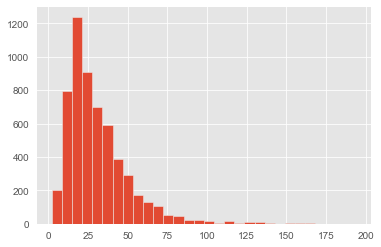

In [837]:
num_tokens = labeled_documents.text.apply(lambda x: len(x.split(" ")))
plt.hist(num_tokens, bins=30);

In [838]:
_set = set()
for __set in labeled_documents.text.apply(lambda x: set(x.split(" "))).values:
    _set = _set.union(__set)
print(f"Number of unique tokens: {len(_set)}")

Number of unique tokens: 18989


In [839]:
# load train/test hashes
#hash_docs_link = pd.read_json("./echo_span_labels/reduced_labels/merged_labels.jsonl", lines=True)[['text', '_input_hash']]
train_ids = pd.read_csv('./train_echoid.csv', sep=',').input_hash.unique()
test_ids = pd.read_csv('./test_echoid.csv', sep=',').input_hash.unique()

labeled_documents['_hash'] = labeled_documents.text.str.strip().apply(lambda x: hash(x))
#hash_docs_link['_hash'] = hash_docs_link.text.str.strip().apply(lambda x: hash(x))

#labeled_documents = labeled_documents.merge(hash_docs_link[['_input_hash', '_hash']], 
#                                            on='_hash', how='inner')

labeled_documents = labeled_documents.drop_duplicates(subset=['_hash']).reset_index(drop=True)

In [840]:
labeled_documents

,text,label,_input_hash,_hash
0,Goede functie van R.V. en L.V. Nog bekijken me...,No label,-1492643194,-8829369265011805554
1,Goede L.V. functie en R.V. functie. Er is een ...,No label,-1268308324,-38610910844393231
2,"Normale dimensie LV. prominent basale septum, ...",No label,-1752879130,-1076752421785114265
3,Goede systolische LV-functie. Matige cLVH. Gee...,Normal,570163096,4292931891081664247
4,Globaal redelijke systolische restfunctie. Voo...,Normal,-1692751703,-708272756211602641
...,...,...,...,...
5744,Technisch beperkt; moeizame echovensters.\r\n\...,No label,-646413772,-1883685935776333483
5745,Matig echo window.\r\n- niet gedilateerde LV m...,No label,-670141983,-1836875323323155183
5746,Normale dimensies en funktie LV. RVF laag norm...,Normal,-623844709,6938213997979499964
5747,"Op dit echo geen duidelijke afwijkingen, goede...",Normal,-79275016,1939100293359204699


In [841]:
# Expand with label columns
if Class == 'merged_labels':
    Target_maps = {
        _Class: {Label:i for i,Label in enumerate(target_df[Class].unique())}
        for _Class in target_df.columns
    }
else:
    Target_maps = {
        Class: {Label: i for i,Label in enumerate(labeled_documents['label'].unique())} 
    }
    
if Class == 'merged_labels':
    DF = labeled_documents[['text', '_input_hash']].join(target_df[Class])
else:
    DF = labeled_documents[['text', '_input_hash', 'label']]

DF.columns = ['sentence', '_input_hash', 'labels']

label2id = Target_maps[Class]
id2label = {v:k for k,v in label2id.items()}
num_labels = len(label2id)

DF= DF.assign(label=DF['labels'].map(label2id))

In [842]:
DF.labels.unique()

array(['No label', 'Normal', 'Mild', 'Moderate', 'Severe'], dtype=object)

## Clean text

In [843]:
DF = DF.assign(sentence=DF.sentence.str.replace(r'[\r\n]', '', regex=True)) 

In [844]:
if lemmatize:
    docs = nlp.pipe(DF.sentence.values)
    new_texts = [" ".join([token.lemma_ for token in doc]) for doc in docs] 
    DF = DF.assign(sentence = new_texts)

if lowercase:
    DF = DF.assign(sentence = DF.sentence.str.lower())
    
if filter_reports:
    DF = DF.assign(sentence = report_filter(DF.sentence)[0])

# Make folds

In [845]:
# prepping
TrainTestDict = defaultdict(dict)

if Splitting == 'from_file':
    TrainTestDict[0]['Xtrain'] = DF.loc[DF._input_hash.isin(train_ids)].sentence
    TrainTestDict[0]['Xtest'] = DF.loc[DF._input_hash.isin(test_ids)].sentence
    
    TrainTestDict[0]['ytrain'] = DF.loc[DF._input_hash.isin(train_ids)].label
    TrainTestDict[0]['ytest'] = DF.loc[DF._input_hash.isin(test_ids)].label
    
elif Splitting == 'CV':
    for k,(train_index, test_index) in enumerate(fold_indices(targets=DF['label'], stratified=True)):
        TrainTestDict[k]['Xtrain'] = DF.iloc[train_index].sentence
        TrainTestDict[k]['Xtest'] = DF.iloc[test_index].sentence
        
        TrainTestDict[k]['ytrain'] = DF.iloc[train_index].label
        TrainTestDict[k]['ytest'] = DF.iloc[test_index].label
    

## Initiate models

In [846]:
if pre_trained_embeddings:
    embedding_dim = nlp.vocab.vectors_length

In [847]:
ModelDict = defaultdict(dict)
for k,v in TrainTestDict.items():
    if pre_trained_embeddings:
        LSTM_Tokenizer = None
        vocab_size = None
    else:
        LSTM_Tokenizer = KerasTokenizer(num_words=num_words_in_vocab)
        LSTM_Tokenizer.fit_on_texts(v['Xtrain'])
        vocab_size = len(LSTM_Tokenizer.word_index)+1

    num_classes = np.unique(v['ytrain']).shape[0]
    
    ModelDict[k]['tokenizer'] = LSTM_Tokenizer
    ModelDict[k]['model'] = CurrentModel(modelselection=ModelType, 
                                         embeddingdim=embedding_dim,
                                         maxlen=max_len,
                                         vocabsize=vocab_size,
                                         numclasses=num_classes,
                                         learningrate=LR,
                                         dilation=dilation,
                                         num_layers=num_layers,
                                         pre_trained_vectors=pre_trained_embeddings
                                         )

# Train

In [848]:
ResultDict = defaultdict(lambda: defaultdict(list))
for k,v in ModelDict.items():
    _model =  v['model']
    _tokenizer = v['tokenizer']
    
    if pre_trained_embeddings:
        X_train = text_to_vectors(TrainTestDict[k]['Xtrain'], max_len) 
        X_test = text_to_vectors(TrainTestDict[k]['Xtest'], max_len) 
    else:
        X_train = _tokenizer.texts_to_sequences(TrainTestDict[k]['Xtrain'])
        X_test = _tokenizer.texts_to_sequences(TrainTestDict[k]['Xtest'])
    
        X_train = pad_sequences(X_train, padding = 'post', maxlen=max_len)
        X_test = pad_sequences(X_test, padding = 'post', maxlen=max_len)

    _y = TrainTestDict[k]['ytrain']
    y_train = utils.to_categorical(_y)

    _y = TrainTestDict[k]['ytest']
    y_test = utils.to_categorical(_y)

    if UseClassWeights:
        PosSum = 1/np.sum(y_train, axis=0)
        ClassWeights = dict(enumerate(PosSum/np.min(PosSum)))
    else:
        ClassWeights = None
    
    result_list = []
    history_list = []
    confusion_list = []
    for epoch_num in range(1, num_epochs+1):
        _history = _model.fit(X_train,
                             y_train,                         
                             epochs = 1,
                             verbose = False,
                             validation_split = 0,
                             class_weight=ClassWeights,
                             batch_size = batch_size)
    
        y_pred = _model.predict(X_test, verbose=False)
        _res = multi_label_metrics(labels=y_test, probs=y_pred)
        
        result_list.append(_res)
        history_list.append({'loss': _history.history['loss'][0], 
                             'accuracy': _history.history['accuracy'][0]})
        confusion_list.append(confusion_matrix(np.argmax(y_test, axis=1),
                                               np.argmax(np.round(y_pred),axis=1),  normalize='true'))
        
        
        print(f"Epoch {epoch_num}, F1 Macro={_res['f1_macro']}")
        
    ResultDict[k]['history'] = pd.DataFrame(history_list)
    ResultDict[k]['result'] = pd.DataFrame(result_list)
    ResultDict[k]['confusion'] = confusion_list
    

D:\VENVS\Envs\nlp_310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\VENVS\Envs\nlp_310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1, F1 Macro=0.11069182389937107


D:\VENVS\Envs\nlp_310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\VENVS\Envs\nlp_310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2, F1 Macro=0.2849316179526952


D:\VENVS\Envs\nlp_310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\VENVS\Envs\nlp_310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3, F1 Macro=0.34035714285714286


D:\VENVS\Envs\nlp_310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\VENVS\Envs\nlp_310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4, F1 Macro=0.3548340349182251


D:\VENVS\Envs\nlp_310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\VENVS\Envs\nlp_310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5, F1 Macro=0.5386822055216284


D:\VENVS\Envs\nlp_310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\VENVS\Envs\nlp_310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6, F1 Macro=0.6990877628891269


D:\VENVS\Envs\nlp_310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\VENVS\Envs\nlp_310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7, F1 Macro=0.7025347462353597


D:\VENVS\Envs\nlp_310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\VENVS\Envs\nlp_310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 8, F1 Macro=0.7298306014608262


D:\VENVS\Envs\nlp_310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\VENVS\Envs\nlp_310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 9, F1 Macro=0.7280989171308185
Epoch 10, F1 Macro=0.7792885406632747
Epoch 11, F1 Macro=0.7777123869212095
Epoch 12, F1 Macro=0.8165451326994345
Epoch 13, F1 Macro=0.8177987227367736
Epoch 14, F1 Macro=0.8229770284433384
Epoch 15, F1 Macro=0.8220413378307218
Epoch 16, F1 Macro=0.8277688882548233
Epoch 17, F1 Macro=0.8561187432056713
Epoch 18, F1 Macro=0.8804985507583106
Epoch 19, F1 Macro=0.8779115213569572
Epoch 20, F1 Macro=0.8801943608409442
Epoch 21, F1 Macro=0.8799092097842349
Epoch 22, F1 Macro=0.8839406236887882
Epoch 23, F1 Macro=0.8837990598282965
Epoch 24, F1 Macro=0.9005407439861799
Epoch 25, F1 Macro=0.8839406236887882
Epoch 26, F1 Macro=0.9044534442016087
Epoch 27, F1 Macro=0.9045952160912856
Epoch 28, F1 Macro=0.9044534442016087
Epoch 29, F1 Macro=0.9044534442016087
Epoch 30, F1 Macro=0.9033205130339601
Epoch 31, F1 Macro=0.904311880341117
Epoch 32, F1 Macro=0.9034620768944519
Epoch 33, F1 Macro=0.9034620768944519
Epoch 34, F1 Macro=0.9033205130339601
Epoch 35, F1 M

Text(0.5, 16.0, 'Predicted label')

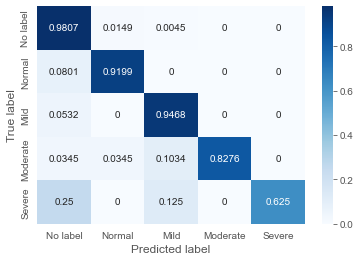

In [849]:
heatmap_df = \
    pd.DataFrame(
    confusion_matrix(np.argmax(y_test, axis=1), np.argmax(np.round(y_pred),axis=1), normalize='true'),
        columns=label2id.keys(),
        index=label2id.keys()
    )
sns.heatmap(heatmap_df.round(4), annot=True, cmap='Blues', fmt='g')
    # df.style.background_gradient(cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [850]:
ResultDict[k]['result'].to_csv(f"../../G_Output/2_Data/results_{Class}_{ModelType}_{Splitting}.csv", sep=";")

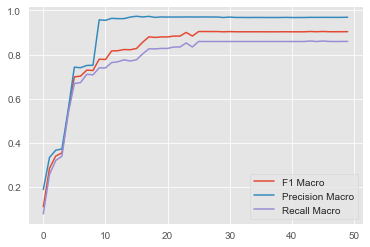

In [851]:
plt.plot(ResultDict[k]['result']['f1_macro'], label='F1 Macro')
plt.plot(ResultDict[k]['result']['prec_macro'], label='Precision Macro')
plt.plot(ResultDict[k]['result']['recall_macro'], label='Recall Macro')
plt.legend(loc='best')
plt.show()

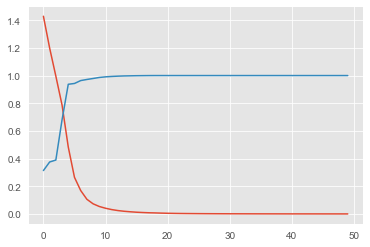

In [852]:
plt.plot(ResultDict[k]['history'])

In [853]:
ResultDict[k]['result']

,f1_macro,f1_weighted,f1_micro,prec_macro,prec_weighted,prec_micro,recall_macro,recall_weighted,recall_micro,roc_auc_macro,roc_auc_weighted,roc_auc_micro,accuracy
0,0.110692,0.163610,0.206250,0.188571,0.278722,0.942857,0.078338,0.115789,0.115789,0.750441,0.778639,0.723728,0.115789
1,0.284932,0.287744,0.411264,0.334064,0.308765,0.811370,0.256923,0.275439,0.275439,0.805070,0.846468,0.815570,0.275439
2,0.340357,0.332545,0.477361,0.366811,0.344026,0.908867,0.320247,0.323684,0.323684,0.873400,0.956422,0.874124,0.323684
3,0.354834,0.338576,0.487460,0.372723,0.345951,0.913253,0.339990,0.332456,0.332456,0.937421,0.978722,0.972182,0.332456
4,0.538682,0.893428,0.909332,0.547276,0.886899,0.917038,0.531720,0.901754,0.901754,0.976465,0.984587,0.983201,0.901754
5,0.699088,0.930463,0.935157,0.743030,0.934204,0.940550,0.668899,0.929825,0.929825,0.985492,0.987351,0.989564,0.929825
6,0.702535,0.933278,0.937748,0.740649,0.937437,0.944000,0.673321,0.931579,0.931579,0.988457,0.990257,0.994169,0.931579
7,0.729831,0.939346,0.943147,0.750946,0.941543,0.947741,0.711118,0.938596,0.938596,0.991227,0.990288,0.995904,0.938596
8,0.728099,0.938905,0.942731,0.751674,0.940621,0.946903,0.708179,0.938596,0.938596,0.991815,0.990828,0.996171,0.938596
9,0.779289,0.943094,0.945791,0.957481,0.951244,0.950399,0.740077,0.941228,0.941228,0.993124,0.990230,0.995924,0.941228


## Upload to huggingface hub